In [1]:
# libraries
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm_notebook as tqdm

scaler = amp.GradScaler()
device = torch.device('cuda')

In [2]:
DEBUG = False
kernel_type = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'
enet_type = 'timm-efficientnet-b1'
data_dir = '../xray_image'
num_workers = 8
image_size = 512
batch_size = 4
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 15 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = 'logs_GAN'
model_dir = 'models_GAN'
# os.makedirs(log_dir, exist_ok=True)
# os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')


In [3]:
L1_lambda = 100

In [4]:
train_df = pd.read_csv(os.path.join(data_dir,'train.csv')).drop('PatientID', axis=1)
train_df.shape

(30083, 12)

In [5]:
train_df_annotations = pd.read_csv(os.path.join(data_dir,'train_annotations.csv'))
train_df_annotations.shape

(17999, 3)

In [6]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    #albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

In [7]:
class RANZCRDataset(Dataset):

    def __init__(self,df, mode, transform=None):

        self.df = df
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(data_dir, image_folder, self.df[index] + '.jpg'))[:, :, ::-1]
        
        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            df_this = train_df_annotations.query(f'StudyInstanceUID == "{self.df[index]}"')
            mask = np.zeros((image.shape[0], image.shape[1], 1)).astype(np.uint8)
            for _, anno in df_this.iterrows():
                anno_this = np.array(ast.literal_eval(anno["data"]))
                mask1 = mask[:,:,0].copy()
                mask1 = cv2.polylines(mask1, np.int32([anno_this]), isClosed=False, color=1, thickness=15, lineType=16)
                mask[:, :, 0] = mask1
            mask = (mask > 0.5).astype(np.uint8)
            res = self.transform(image=image, mask=mask)
            
        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0,1)
            return torch.tensor(image), torch.tensor(mask)

In [8]:
train_files = train_df_annotations['StudyInstanceUID'].unique()
len(train_files)

9095

In [9]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 8))
    for i, (name, image) in enumerate(images.items()):
        if image.shape[0] == 3:
            image = image.numpy()
            image = image.transpose((1,2,0))
        elif image.shape[0] == 1:
            image = image.numpy()
            image = image.reshape(image.shape[1],image.shape[2])
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
dataset_show = RANZCRDataset(train_files,'train', transform=transforms_train)

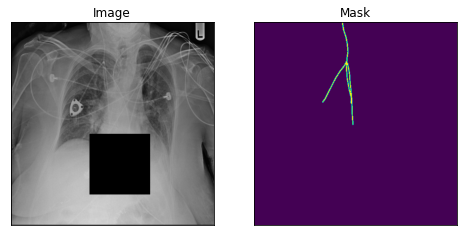

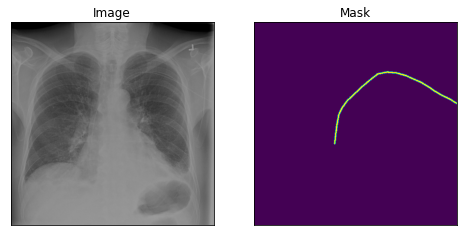

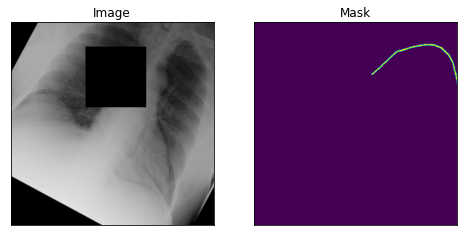

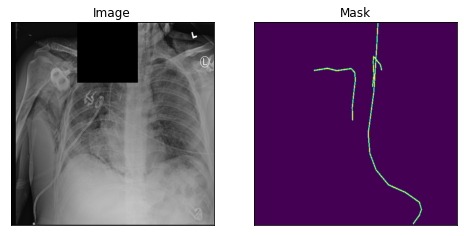

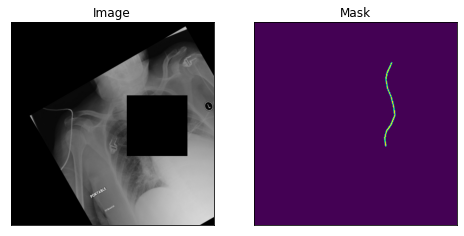

In [11]:
# visualizing some training data with augmentations implied
for i in range(5):
    image, mask = dataset_show[i]
    visualize(image=image, mask=mask)

In [10]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights='imagenet', classes=1, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features

m = SegModel(enet_type)
m(torch.rand(2,3,224,224)).shape

torch.Size([2, 1, 224, 224])

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

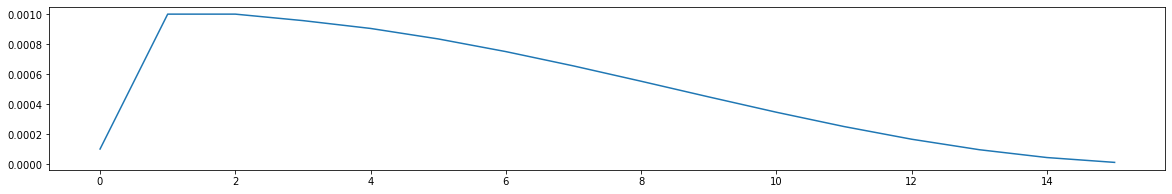

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizerS = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerS, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizerS, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizerS.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
                
        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False)
            #nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.structure(x)
m = Discriminator()
m(torch.rand(1,4,224,224)).shape

torch.Size([1, 1, 26, 26])

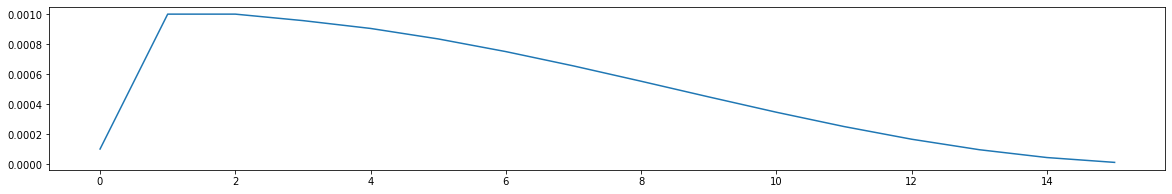

In [15]:
optimizer1 = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer1, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer1.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [16]:
def dice_loss(input,target):
    num=input*target
    num=torch.sum(num,dim=2)
    num=torch.sum(num,dim=2)

    den1=input*input
    den1=torch.sum(den1,dim=2)
    den1=torch.sum(den1,dim=2)

    den2=target*target
    den2=torch.sum(den2,dim=2)
    den2=torch.sum(den2,dim=2)

    dice=2*(num/(den1+den2))

    dice_total=1-1*torch.sum(dice)/dice.size(0)#divide by batchsize

    return dice_total

In [17]:
def train_epoch(modelG, modelD, loader, optimizerG,optimizerD):

    modelG.train()
    modelD.train()
    trainG_loss = []
    trainD_loss = []
    bar = tqdm(loader)
    for (data, mask) in bar:

        optimizerD.zero_grad()
        data, mask = data.to(device), mask.to(device)
        real_data = torch.cat([data, mask], dim=1).to(device)
        
        #Real data
        outputs = modelD(real_data) # label "real" data
        labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
        lossD_real = criterion(outputs, labels) # divide the objective by 2 -> slow down D
              
        #Fake Data
        gens = modelG(data).detach()
        fake_data = torch.cat([data, gens], dim=1) # generated image data
        
        outputs = modelD(fake_data)
        labels = torch.zeros(size = outputs.shape, dtype=torch.float, device=device) # label "fake" data
        lossD_fake = criterion(outputs, labels) # divide the objective by 2 -> slow down D
        #lossD_fake.backward()
        lossD = (lossD_fake + lossD_real) * 0.5
        lossD.backward()
        optimizerD.step()
        trainD_loss.append(lossD.item())
        
#         for i in range(2):
        optimizerG.zero_grad()
        with amp.autocast():
            gens = modelG(data)
            gen_data = torch.cat([data, gens], dim=1)
            with torch.no_grad():
                outputs = modelD(gen_data)
            labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
            loss = criterion(outputs, labels) + dice_loss(mask,gens)#criterion2(mask,gens)*100#L1_lambda * torch.abs(gens-mask).sum()
        scaler.scale(loss).backward()
        scaler.step(optimizerG)
        scaler.update()

        loss_np = loss.item()
        trainG_loss.append(loss_np)
        smooth_loss = sum(trainG_loss[-50:]) / min(len(trainG_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(trainG_loss),np.mean(trainD_loss)

In [46]:
def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    with torch.no_grad():
        for (data, mask) in tqdm(loader):
            data, mask = data.to(device), mask.to(device)
            logits = model(data)
            loss = criterion(logits, mask)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())

    if get_output:
        LOGITS = torch.cat(LOGITS, 0).float().sigmoid()
        return LOGITS
    else:
        val_loss = np.mean(val_loss)
        return val_loss

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(train_files,random_state = 42, test_size = 0.2)

In [13]:
print(len(X_train),len(X_val))

7276 1819


In [21]:
def weights_init(m):
    name = m.__class__.__name__
    
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [20]:
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.L1Loss()


Sat May  1 20:36:07 2021 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sat May  1 21:10:47 2021 Epoch 1,lrG: 0.0001000, lrD: 0.0001000 trainG loss: 5.20660,trainD loss: 0.07675, valid loss: 0.69413.


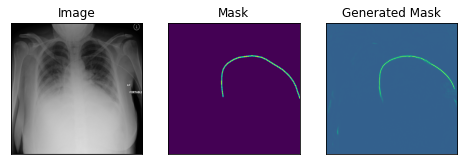

Validation loss decreased (inf --> 0.694127).  Saving model ...
Sat May  1 21:10:48 2021 Epoch: 2


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sat May  1 21:45:28 2021 Epoch 2,lrG: 0.0010000, lrD: 0.0010000 trainG loss: 1.16403,trainD loss: 0.69675, valid loss: 0.69392.


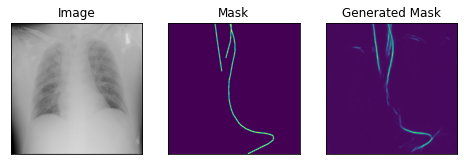

Validation loss decreased (0.694127 --> 0.693924).  Saving model ...
Sat May  1 21:45:29 2021 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sat May  1 22:20:11 2021 Epoch 3,lrG: 0.0010000, lrD: 0.0010000 trainG loss: 4.93119,trainD loss: 0.09861, valid loss: 0.69482.


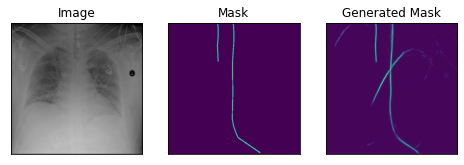

Sat May  1 22:20:12 2021 Epoch: 4


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sat May  1 22:54:52 2021 Epoch 4,lrG: 0.0009568, lrD: 0.0009568 trainG loss: 6.16957,trainD loss: 0.08873, valid loss: 0.69389.


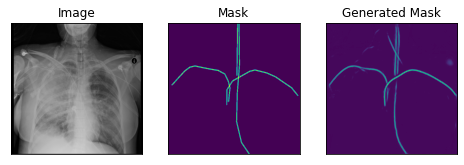

Validation loss decreased (0.693924 --> 0.693891).  Saving model ...
Sat May  1 22:54:53 2021 Epoch: 5


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sat May  1 23:29:33 2021 Epoch 5,lrG: 0.0009045, lrD: 0.0009045 trainG loss: 8.20800,trainD loss: 0.02042, valid loss: 0.69399.


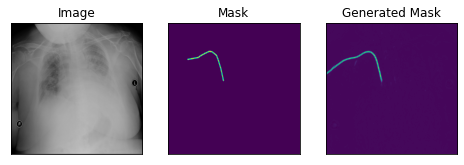

Sat May  1 23:29:34 2021 Epoch: 6


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sun May  2 00:04:13 2021 Epoch 6,lrG: 0.0008346, lrD: 0.0008346 trainG loss: 9.41964,trainD loss: 0.05112, valid loss: 0.69381.


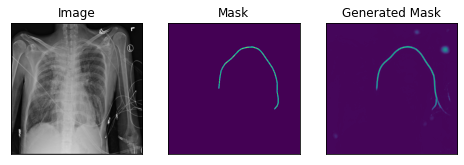

Validation loss decreased (0.693891 --> 0.693815).  Saving model ...
Sun May  2 00:04:15 2021 Epoch: 7


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sun May  2 00:38:53 2021 Epoch 7,lrG: 0.0007500, lrD: 0.0007500 trainG loss: 11.43145,trainD loss: 0.00373, valid loss: 0.69349.


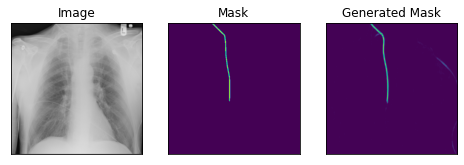

Validation loss decreased (0.693815 --> 0.693493).  Saving model ...
Sun May  2 00:38:55 2021 Epoch: 8


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sun May  2 01:13:32 2021 Epoch 8,lrG: 0.0006545, lrD: 0.0006545 trainG loss: 9.93307,trainD loss: 0.04310, valid loss: 0.69379.


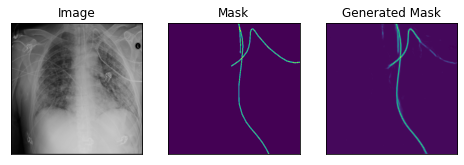

Sun May  2 01:13:33 2021 Epoch: 9


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sun May  2 01:48:12 2021 Epoch 9,lrG: 0.0005523, lrD: 0.0005523 trainG loss: 11.52458,trainD loss: 0.00380, valid loss: 0.69381.


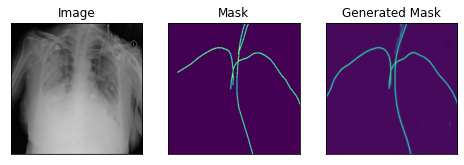

Sun May  2 01:48:13 2021 Epoch: 10


  0%|          | 0/1819 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

Sun May  2 02:22:52 2021 Epoch 10,lrG: 0.0004477, lrD: 0.0004477 trainG loss: 10.68612,trainD loss: 0.05164, valid loss: 0.69348.


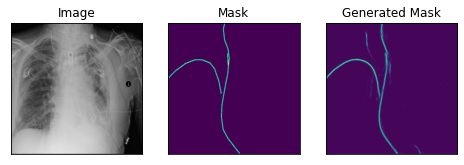

Validation loss decreased (0.693493 --> 0.693481).  Saving model ...
Sun May  2 02:22:53 2021 Epoch: 11


  0%|          | 0/1819 [00:00<?, ?it/s]

In [ ]:
content = ''
print(content)
with open(log_file, 'a') as appender:
    appender.write(content + '\n')

dataset_train = RANZCRDataset(X_train, 'train', transform=transforms_train)
dataset_valid = RANZCRDataset(X_val, 'valid', transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=num_workers)

modelG = SegModel(enet_type)
modelG = modelG.to(device)
val_loss_min = np.Inf

modelD = Discriminator()
modelD.apply(weights_init)
modelD = modelD.to(device)

optimizerD = optim.Adam(modelD.parameters(), lr=init_lr)
schedulerD_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD, cosine_epo)
schedulerD_warmup = GradualWarmupSchedulerV2(optimizerD, multiplier=10, total_epoch=warmup_epo, after_scheduler=schedulerD_cosine)

optimizerG = optim.Adam(modelG.parameters(), lr=init_lr)
schedulerG_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, cosine_epo)
schedulerG_warmup = GradualWarmupSchedulerV2(optimizerG, multiplier=10, total_epoch=warmup_epo, after_scheduler=schedulerG_cosine)
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    schedulerD_warmup.step(epoch-1)
    schedulerG_warmup.step(epoch-1)

    trainG_loss,trainD_loss = train_epoch(modelG,modelD, train_loader, optimizerG,optimizerD)
    val_loss = valid_epoch(modelG, valid_loader)

    content = time.ctime() + ' ' +\
                f'Epoch {epoch},lrG: {optimizerG.param_groups[0]["lr"]:.7f}, lrD: {optimizerD.param_groups[0]["lr"]:.7f} '+\
                f'trainG loss: {trainG_loss:.5f},trainD loss: {trainD_loss:.5f}, valid loss: {(val_loss):.5f}.'
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    with torch.no_grad():
        k = np.random.randint(0,len(dataset_valid))
        img,mask = dataset_valid[k]
        x_tensor = img.to(device).unsqueeze(0)
        pr_mask = modelG(x_tensor)
        pr_mask = pr_mask.squeeze().cpu()
        #pr_mask = (pr_mask > 0.5).numpy().astype(np.uint8)
        visualize(image=img,mask=mask,generated_mask = pr_mask)
        
    stateD = {'epoch': epoch, 'state_dict': modelD.state_dict(),
             'optimizer': optimizerD.state_dict(),'val_loss':val_loss}
    torch.save(stateD,os.path.join(model_dir,'Discriminator.pth'))
    stateD = {'epoch': epoch, 'state_dict': modelG.state_dict(),
             'optimizer': optimizerG.state_dict(),'val_loss':val_loss}
    torch.save(stateD,os.path.join(model_dir,'Generator.pth'))
    
       

    if val_loss_min > val_loss:
        modelG_file = os.path.join(model_dir, f'generator_best_epoch{epoch}.pth')
        modelD_file = os.path.join(model_dir, f'Discriminator_best_epoch{epoch}.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
        torch.save(modelG.state_dict(), modelG_file)
        torch.save(modelD.state_dict(), modelD_file)
        val_loss_min = val_loss

In [14]:
modelG = SegModel(enet_type)
modelG = modelG.to(device)
modelG_file = os.path.join(model_dir, f'generator_best_epoch16.pth')
modelG.load_state_dict(torch.load(modelG_file), strict=False)
modelG.eval()

SegModel(
  (seg): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True

In [15]:
with torch.no_grad():
        k = np.random.randint(0,len(dataset_valid))
        img,mask = dataset_valid[k]
        x_tensor = img.to(device).unsqueeze(0)
        pr_mask = modelG(x_tensor)
        pr_mask = pr_mask.squeeze().cpu()
        #pr_mask = (pr_mask > 0.5).numpy().astype(np.uint8)
        visualize(image=img,mask=mask,generated_mask = pr_mask)

NameError: name 'dataset_valid' is not defined

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

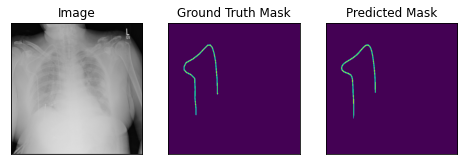

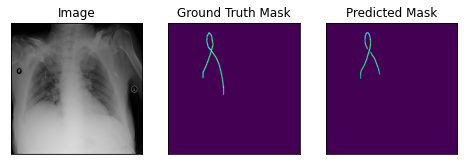

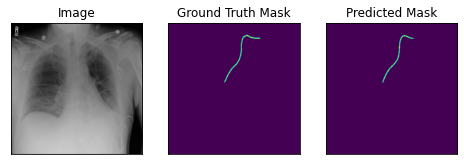

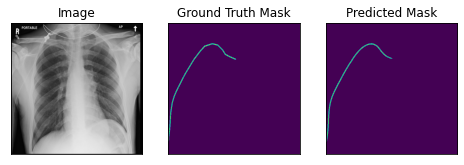

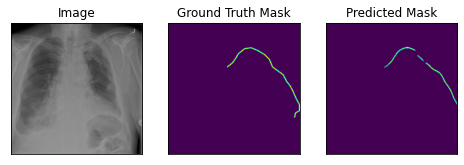

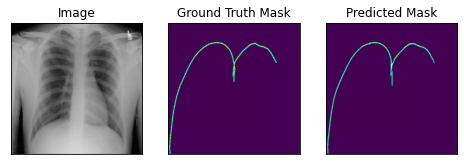

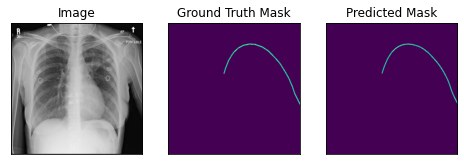

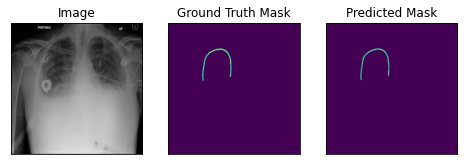

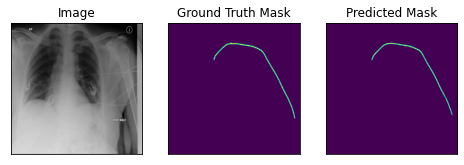

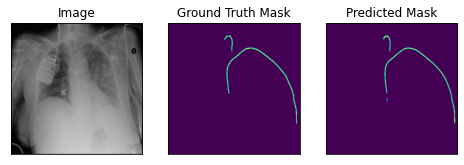

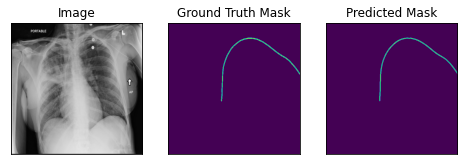

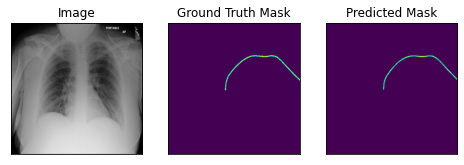

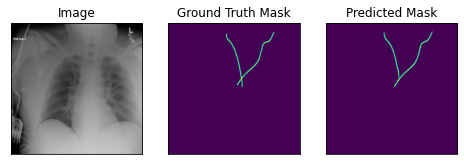

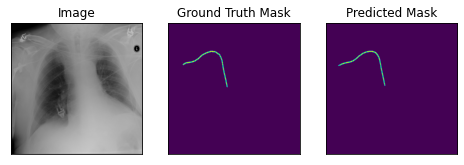

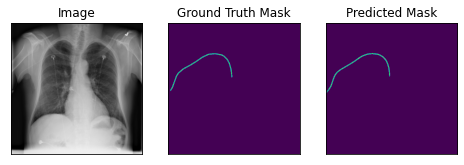

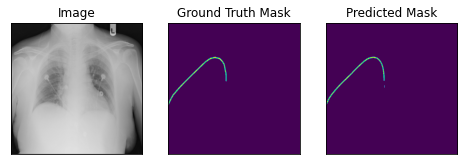

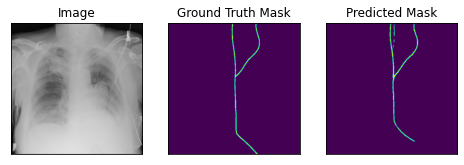

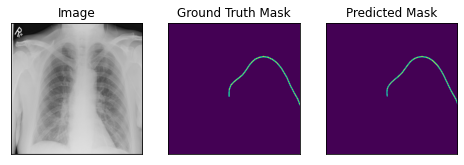

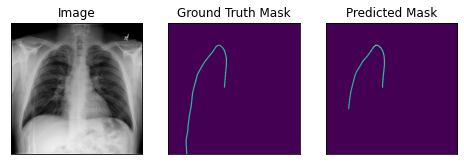

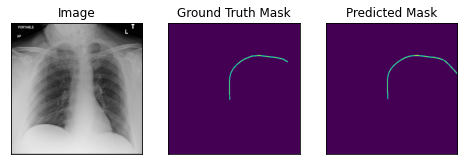

In [32]:
dataset_valid = RANZCRDataset(train_files, 'valid', transform=transforms_val)
sig = nn.Sigmoid()
with torch.no_grad():
    for i,j in tqdm(enumerate(train_files[40:60])):
        image, gt_mask = dataset_valid[i+40]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))>0.65).float()
        pr_mask = pr_mask.squeeze().cpu()#.round()
        #pr_mask = sig(pr_mask).numpy()
        #print(pr_mask.shape)
#         png = (pr_mask * 255).astype(np.uint8)[:,:,np.newaxis]
#         png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 2))], -1)
#         cv2.imwrite(os.path.join(output_dir, f'{j}.png'), png)
        
        visualize(image=image,ground_truth_mask=gt_mask,predicted_mask=pr_mask)

In [17]:
len(train_df.StudyInstanceUID.unique())-len(train_files)

20988

In [18]:
all_files = train_df.StudyInstanceUID.unique()
len(all_files)

30083

In [19]:
no_mask_files = [i for i in all_files if i not in train_files]
len(no_mask_files)

20988

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

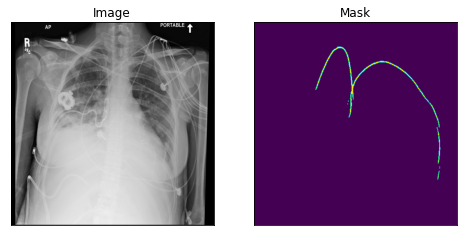

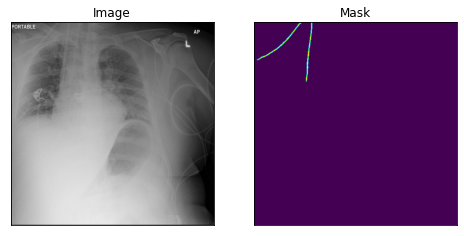

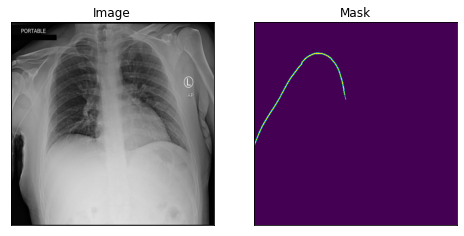

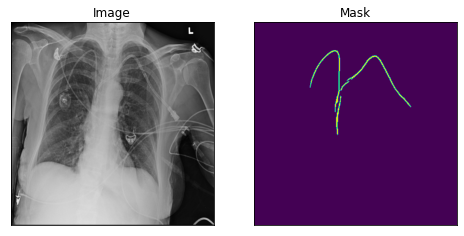

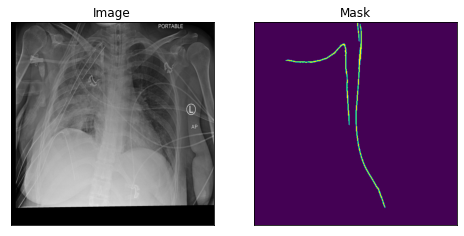

In [44]:
#random = np.random.choice(no_mask_files,10)
random = no_mask_files[10:15]
dataset_no_mask = RANZCRDataset(random, 'test', transform=transforms_val)
sig = nn.Sigmoid()
with torch.no_grad():
    for i,j in tqdm(enumerate(random)):
        image = dataset_no_mask[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))>0.65).float()
        pr_mask = pr_mask.squeeze().cpu()#.round()
        visualize(image=image,mask=pr_mask)
#         png = (pr_mask * 255).astype(np.uint8)[:,:,np.newaxis]
#         png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 2))], -1)
#         cv2.imwrite(os.path.join(output_dir, f'{j}.png'), png)
    

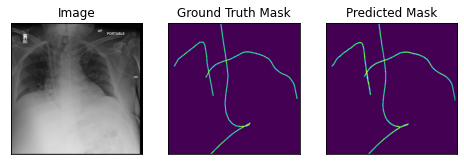

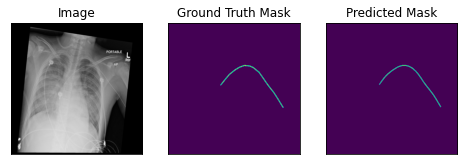

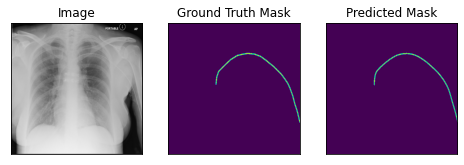

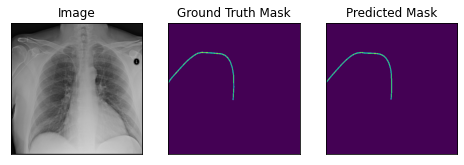

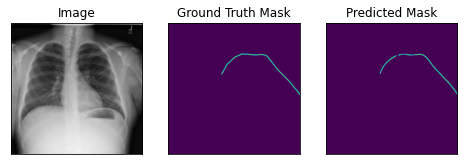

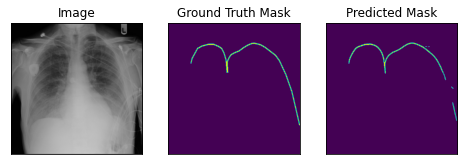

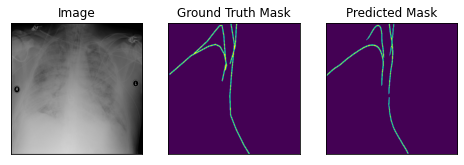

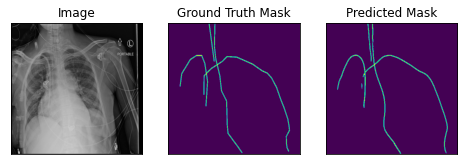

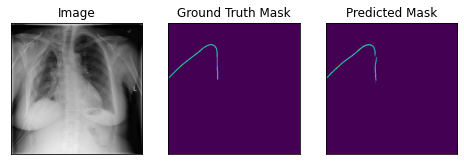

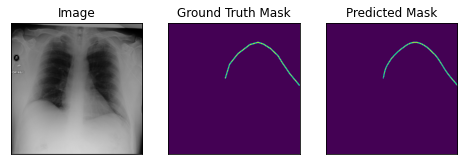

In [48]:
random = np.random.choice(X_val,10)
dataset_no_mask = RANZCRDataset(random, 'valid', transform=transforms_val)
with torch.no_grad():
    for i,j in enumerate(random):
        image, gt_mask = dataset_no_mask[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))>0.65).float()
        pr_mask = pr_mask.squeeze().cpu()#.round()
        #pr_mask = (sig(pr_mask).numpy()>0.6).astype(int)
    #gmask = cv2.cvtColor(np.float32(image),cv2.COLOR_BGR2RGB)
        visualize(image=image,ground_truth_mask=gt_mask,predicted_mask=pr_mask)

In [21]:
#dataset_train = RANZCRDataset(X_train, 'train', transform=transforms_train)
dataset_valid = RANZCRDataset(X_val, 'valid', transform=transforms_val)
#train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=num_workers)
val_loss = valid_epoch(modelG, valid_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/455 [00:00<?, ?it/s]

In [22]:
val_loss

0.6921305461244269